In [10]:
import sympy as sp
from sympy import *
import numpy as np
from opt_einsum import contract as _contract
import itertools as itt
from IPython.display import display, Latex
init_printing()

def contract(expr,*tensors,**args):
    if contract.dest is not None:
        expr+='->'+contract.dest
    rtval= _contract(expr,*tensors, backend='object',**args)
    return rtval.item() if rtval.shape==() else Array(rtval)
    
class contract_dest:
    def __init__(self, dest):
        self.dest= dest
    def __enter__(self):
        contract.dest,self.dest= self.dest,contract.dest
    def __exit__(self, *args):
        contract.dest= self.dest
contract.dest=None


def print_nonzero_terms(v):
    for i in itt.product(*[range(d) for d in v.shape]):
        if v[i]!=0:
            print(i,v[i])

def get_covariant_derivative(coords, Gm=None):
    def covariant_derivative(v,indice_positions=''):
        ''' a: tensor, indice_positions: list of index type
            index types:
                - 'i': internal, 
                - 'u': curved upper, 'd' curved lower
        '''
        rtval=derive_by_array(v,coords)
        for i,ind in enumerate(indice_positions):
            if ind=='u': # D_u T^v=∂_u T^v+Γ^v_ur T^r
                rtval+=np.swapaxes(contract('vur,r...->uv...',Gm,np.swapaxes(v,0,i)),1,i+1)
            elif ind=='d': # D_u T_v=∂_u T_v-Γ^r_uv T^r
                rtval-=np.swapaxes(contract('ruv,r...->uv...',Gm,np.swapaxes(v,0,i)),1,i+1)
        return Array(simplify(rtval))
    return covariant_derivative


# Spherical symmetry with zero cosmological constant

In [11]:
t,r,th,phi=coords=symbols('t,r,theta,phi')
fFunc=Function('f')(r)
gFunc=Function('g')(r)
df=diff(fFunc,r)
dg=diff(gFunc,r)
ddf=diff(fFunc,r,r)
ddg=diff(gFunc,r,r)

g=diag(-fFunc,gFunc,r**2,r**2*sin(th)**2)

display(g)

⎡-f(r)   0    0       0     ⎤
⎢                           ⎥
⎢  0    g(r)  0       0     ⎥
⎢                           ⎥
⎢              2            ⎥
⎢  0     0    r       0     ⎥
⎢                           ⎥
⎢                  2    2   ⎥
⎣  0     0    0   r ⋅sin (θ)⎦

In [12]:
# Γ^k_ij=1/2 g^kl (∂_i g_jl+∂_j g_il-∂_l g_ij)
ginv=g.inv()
dg=derive_by_array(g,coords)
with contract_dest('kij'):
    Gm=(contract('kl,ijl',ginv,dg)+contract('kl,jil',ginv,dg)-contract('kl,lij',ginv,dg))/2

# R^r_smn=∂m Γ^r_ns - ∂n Γ^r_ms +Γ^r_ml Γ^l_ns - Γ^r_nl Γ^l_ms
dGm=derive_by_array(Gm,coords)
with contract_dest('rsmn'):
    Rie=contract('mrns',dGm)-contract('nrms',dGm)+contract('rml,lns',Gm,Gm)-contract('rnl,lms',Gm,Gm)


# R_ij=R^r_irj
with contract_dest('ij'):
    Ric=contract('rirj',Rie)

RicS=contract('ij,ij',Ric,ginv)
RicS=expand(RicS)

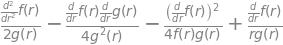

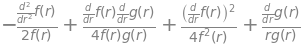

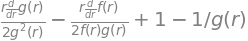

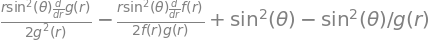

In [13]:
eq1=expand(Ric[0,0])
eq2=expand(Ric[1,1])
eq3=expand(Ric[2,2])
eq4=expand(Ric[3,3])

display(eq1)
display(eq2)
display(eq3)
display(eq4)

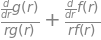

In [14]:
expand(eq1*gFunc/fFunc+eq2)

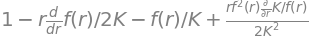

In [15]:
K=symbols('K')
eq=expand(eq3.subs(gFunc,K/fFunc))
eq

In [16]:
dsolve(eq)

# Spherical Symmetry with cosmological constant

In [78]:
AdSRad=symbols('L')
cosmos_const=-3/AdSRad**2

t,r,th,phi=coords=symbols('t,r,theta,phi')
fFunc=Function('f')(r)
gFunc=Function('g')(r)
df=diff(fFunc,r)
dg=diff(gFunc,r)
ddf=diff(fFunc,r,r)
ddg=diff(gFunc,r,r)
g=diag(-fFunc,gFunc,r**2,r**2*sin(th)**2)

display(g)

⎡-f(r)   0    0       0     ⎤
⎢                           ⎥
⎢  0    g(r)  0       0     ⎥
⎢                           ⎥
⎢              2            ⎥
⎢  0     0    r       0     ⎥
⎢                           ⎥
⎢                  2    2   ⎥
⎣  0     0    0   r ⋅sin (θ)⎦

In [79]:
# spacial dim, g^mn, ∂_i g^mn
ginv=g.inv()

# Γ^k_ij=1/2 g^kl (∂_i g_jl+∂_j g_il-∂_l g_ij)
dg=derive_by_array(g,coords)
with contract_dest('kij'):
    Gm=(contract('kl,ijl',ginv,dg)+contract('kl,jil',ginv,dg)-contract('kl,lij',ginv,dg))/2
# display(Gm)

# R^r_smn=∂m Γ^r_ns - ∂n Γ^r_ms +Γ^r_ml Γ^l_ns - Γ^r_nl Γ^l_ms
dGm=derive_by_array(Gm,coords)
with contract_dest('rsmn'):
    Rie=contract('mrns',dGm)-contract('nrms',dGm)+contract('rml,lns',Gm,Gm)-contract('rnl,lms',Gm,Gm)


# R_ij=R^r_irj
with contract_dest('ij'):
    Ric=contract('rirj',Rie)

RicS=contract('ij,ij',Ric,ginv)
RicS=expand(RicS)

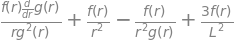

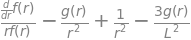

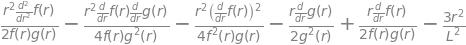

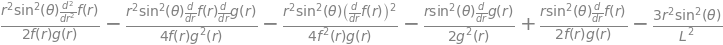

In [80]:
# R_ij-1/2 g_ij R + Λ g_ij=0

eqT=Ric+Array(g)*(cosmos_const-RicS/2)

eq1=expand(eqT[0,0])
eq2=expand(eqT[1,1])
eq3=expand(eqT[2,2])
eq4=expand(eqT[3,3])

display(eq1)
display(eq2)
display(eq3)
display(eq4)

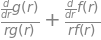

In [81]:
expand(eq1*gFunc/fFunc+eq2)


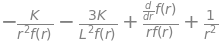

In [82]:
K=symbols('K')
eq=expand(eq2.subs(gFunc,K/fFunc))
eq

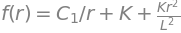

In [83]:
dsolve(eq)

# Planar Symmetry with some cosmological constant

In [108]:
AdSRad=symbols('L')
cosmos_const=-3/AdSRad**2

t,eta,x,y=coords=symbols('t,eta,x,y')
fFunc=Function('f')(eta)
gFunc=Function('g')(eta)
g=diag(-exp(fFunc),1,exp(fFunc),exp(fFunc))

display(g)

⎡  f(η)                 ⎤
⎢-ℯ      0    0      0  ⎥
⎢                       ⎥
⎢  0     1    0      0  ⎥
⎢                       ⎥
⎢            f(η)       ⎥
⎢  0     0  ℯ        0  ⎥
⎢                       ⎥
⎢                   f(η)⎥
⎣  0     0    0    ℯ    ⎦

In [109]:
ginv=g.inv()


# Γ^k_ij=1/2 g^kl (∂_i g_jl+∂_j g_il-∂_l g_ij)
dg=derive_by_array(g,coords)
with contract_dest('kij'):
    Gm=(contract('kl,ijl',ginv,dg)+contract('kl,jil',ginv,dg)-contract('kl,lij',ginv,dg))/2
# display(Gm)


# R^r_smn=∂m Γ^r_ns - ∂n Γ^r_ms +Γ^r_ml Γ^l_ns - Γ^r_nl Γ^l_ms
dGm=derive_by_array(Gm,coords)
with contract_dest('rsmn'):
    Rie=contract('mrns',dGm)-contract('nrms',dGm)+contract('rml,lns',Gm,Gm)-contract('rnl,lms',Gm,Gm)


# R_ij=R^r_irj
with contract_dest('ij'):
    Ric=contract('rirj',Rie)

RicS=contract('ij,ij',Ric,ginv)
RicS=expand(RicS)

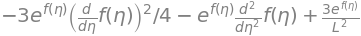

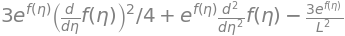

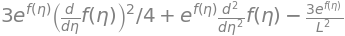

In [110]:
# R_ij-1/2 g_ij R + Λ g_ij=0

eqT=Ric+Array(g)*(cosmos_const-RicS/2)

eq1=expand(eqT[0,0])
eq2=expand(eqT[1,1])
eq3=expand(eqT[2,2])
eq4=expand(eqT[3,3])

display(eq1)
display(eq2)
display(eq3)
display(eq4)

In [120]:
fsubs1,fsubs2=dsolve(eq2)
display(fsubs1,fsubs2)

In [112]:
display(eq1.subs(fFunc,fsubs1.rhs).doit())
display(eq2.subs(fFunc,fsubs1.rhs).doit())
display(eq3.subs(fFunc,fsubs1.rhs).doit())
display(eq4.subs(fFunc,fsubs1.rhs).doit())

In [118]:
display(g.subs(fFunc,fsubs1.rhs).doit())
display(Ric.subs(fFunc,fsubs1.rhs).doit())
display(RicS.subs(fFunc,fsubs1.rhs).doit())

⎡       2⋅η                         ⎤
⎢  C₁ + ───                         ⎥
⎢        L                          ⎥
⎢-ℯ          0      0          0    ⎥
⎢                                   ⎥
⎢    0       1      0          0    ⎥
⎢                                   ⎥
⎢                     2⋅η           ⎥
⎢                C₁ + ───           ⎥
⎢                      L            ⎥
⎢    0       0  ℯ              0    ⎥
⎢                                   ⎥
⎢                                2⋅η⎥
⎢                           C₁ + ───⎥
⎢                                 L ⎥
⎣    0       0      0      ℯ        ⎦

⎡        2⋅η                                   ⎤
⎢   C₁ + ───                                   ⎥
⎢         L                                    ⎥
⎢3⋅ℯ                                           ⎥
⎢───────────   0         0              0      ⎥
⎢      2                                       ⎥
⎢     L                                        ⎥
⎢                                              ⎥
⎢             -3                               ⎥
⎢     0       ───        0              0      ⎥
⎢               2                              ⎥
⎢              L                               ⎥
⎢                                              ⎥
⎢                           2⋅η                ⎥
⎢                      C₁ + ───                ⎥
⎢                            L                 ⎥
⎢                  -3⋅ℯ                        ⎥
⎢     0        0   ─────────────        0      ⎥
⎢                         2                    ⎥
⎢                        L                     ⎥
⎢                   